In [82]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [84]:
def hard_thresholding(x: torch.Tensor, threshold: torch.Tensor) -> torch.Tensor:
    """Non-differentiable with regard to threshold"""
    return torch.where(torch.abs(x) > threshold, x, torch.zeros_like(x))


def soft_thresholding(x: torch.Tensor, threshold: torch.Tensor) -> torch.Tensor:
    """Differentiable with regard to threshold, does not preserve energy of input signal (biased)"""
    return torch.nn.functional.relu(x - threshold) - torch.nn.functional.relu(-(x + threshold))


def assym_differentiable_hard_thresholding(x: torch.Tensor, threshold: torch.Tensor, temperature: float=1) -> torch.Tensor:
    x_offset = x - threshold
    return torch.nn.functional.relu(x_offset + threshold*torch.tanh(x_offset/temperature))


def differentiable_hard_thresholding(x: torch.Tensor, threshold: torch.Tensor, temperature: float=1) -> torch.Tensor:
    """Approximated of hard thresholding, differentiable with regard to threshold
    When temperature is high, it is close to soft thresholding
    When temperature is close to 0, it is close to hard thresholding
    """
    return assym_differentiable_hard_thresholding(x, threshold, temperature) - assym_differentiable_hard_thresholding(-x, threshold, temperature)



In [85]:
inp = 8*torch.randn(2000)
thresh_gt = 2.4
out_gt = hard_thresholding(inp, thresh_gt)

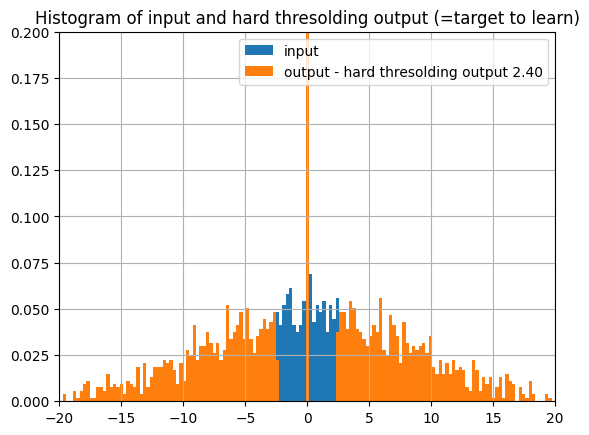

In [86]:
# plt.plot(inp, "o")
# plt.plot(out_gt, "+")
# plt.show()
plt.figure()
plt.hist(inp.detach().numpy(), bins=200, label="input", density=True)
plt.hist(out_gt.detach().numpy(), bins=200, label=f"output - hard thresolding output {thresh_gt:.2f}", density=True)
plt.legend()
plt.xlim(-20, 20)
plt.ylim(0, 0.2)
plt.grid()
plt.title("Histogram of input and hard thresolding output (=target to learn)")
plt.show()

In [87]:
learnable_threshold_soft = torch.nn.Parameter(1.*torch.ones(1))
optimizer = torch.optim.SGD([learnable_threshold_soft], lr=0.001)
losses_soft = []
learnt_tresh_soft = []
total_steps = 4000
for step in range(total_steps):
    optimizer.zero_grad()
    out_pred = soft_thresholding(inp, learnable_threshold_soft)
    error = torch.mean((out_pred - out_gt)**2)
    error.backward()
    optimizer.step()
    losses_soft.append(error.item())
    learnt_tresh_soft.append(learnable_threshold_soft.detach().item())


In [88]:
learnable_threshold = torch.nn.Parameter(1.*torch.ones(1))
optimizer = torch.optim.SGD([learnable_threshold], lr=0.01)
losses = []
learnt_tresh = []
total_steps = 4000
for step in range(total_steps):
    temperature = 1e-3+ np.linspace(5, 0., num=total_steps, endpoint=True)[step]
    optimizer.zero_grad()
    out_pred = differentiable_hard_thresholding(inp, learnable_threshold, temperature=temperature)
    error = torch.mean((out_pred - out_gt)**2)
    error.backward()
    optimizer.step()
    losses.append(error.item())
    learnt_tresh.append(learnable_threshold.detach().item())
print(temperature)


0.001


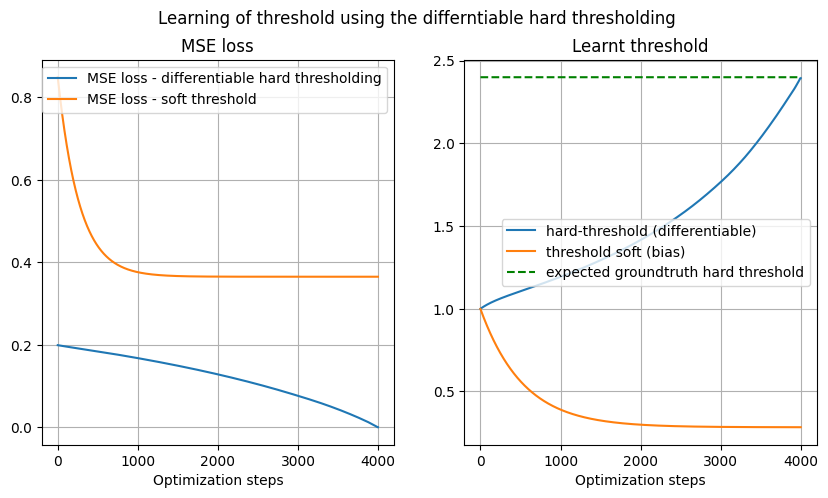

In [89]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label="MSE loss - differentiable hard thresholding")
plt.plot(losses_soft, label="MSE loss - soft threshold")
plt.title("MSE loss")
plt.grid()
plt.xlabel("Optimization steps")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(learnt_tresh, label="hard-threshold (differentiable)")
plt.plot(learnt_tresh_soft, label="threshold soft (bias)")
plt.plot([thresh_gt]*len(losses), "g--", label="expected groundtruth hard threshold")
plt.title("Learnt threshold")
plt.xlabel("Optimization steps")
plt.grid()
plt.legend()
plt.suptitle("Learning of threshold using the differntiable hard thresholding")
plt.show()

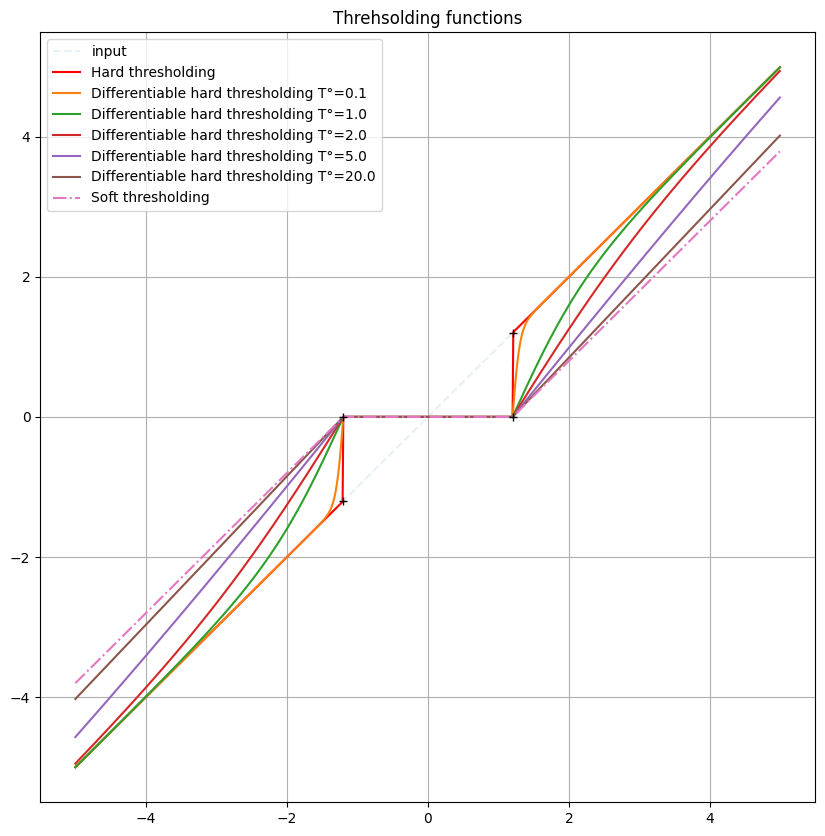

In [90]:

inp = torch.arange(-5, 5, 0.01)
thresh = 1.2
threshold = torch.nn.Parameter(thresh*torch.ones(1))
out_hard = hard_thresholding(inp, threshold)
out_soft = soft_thresholding(inp, threshold)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(inp, inp.detach().numpy(), "--", alpha=0.1, label="input")
plt.plot(inp, out_hard.detach().numpy(), "r-", label="Hard thresholding")
for temperature in [0.1, 1., 2., 5., 20.]:
    out_dhard = differentiable_hard_thresholding(inp, threshold, temperature=temperature)
    plt.plot(inp, out_dhard.detach().numpy(), "-", label=f"Differentiable hard thresholding T°={temperature}")
plt.plot(inp, out_soft.detach().numpy(), "-.", label="Soft thresholding")
plt.plot([thresh, thresh], [0, thresh], "k+")
plt.plot([-thresh, -thresh], [0, -thresh], "k+")
plt.title("Threhsolding functions")
plt.legend()
plt.grid()
plt.show()

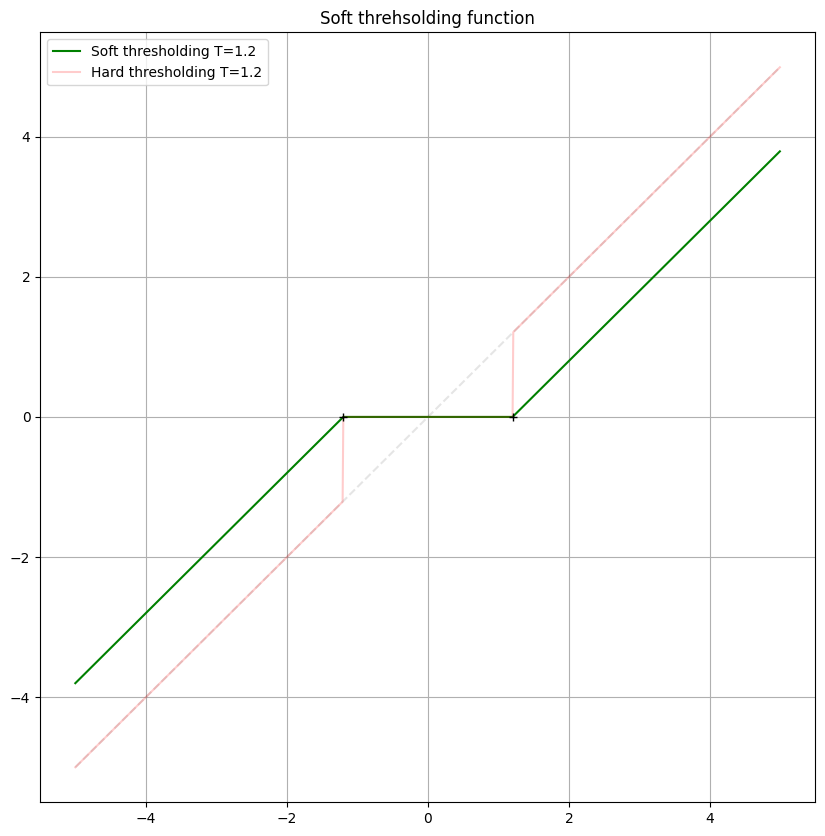

In [102]:
inp = torch.arange(-5, 5, 0.01)
thresh = 1.2
threshold = torch.nn.Parameter(thresh*torch.ones(1))
out_hard = hard_thresholding(inp, threshold)
out_soft = soft_thresholding(inp, threshold)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(inp, inp.detach().numpy(), "k--", alpha=0.1)
plt.title("Soft threhsolding function")
plt.plot(inp, out_soft.detach().numpy(), "g-", label=f"Soft thresholding T={thresh}")
plt.plot(inp, out_hard.detach().numpy(), "r-", label=f"Hard thresholding T={thresh}", alpha=0.2)
plt.plot([thresh], [0], "k+")
plt.plot([-thresh], [0], "k+")
plt.legend()
plt.grid()
plt.show()